# Event-Driven Data Preprocessing Lab

## Setup

1. We need to install kafka-python and PyMongo

In [1]:
!pip install kafka-python pymongo pandas matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.


2. We import **kafka-python** and **PyMongo** to read events and entities.   
We also import extra libraries for json manipulation:  
`JSON` and `json.loads` will help us to visualize the generated json.

In [2]:
from IPython.display import JSON
import json
import pandas as pd
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from pymongo import MongoClient

3. We set the addresses: kafka, mongo, inspector

In [3]:
event_store = 'localhost:9092'
entity_store = 'mongodb://localhost:27017/'
inspector_api = 'http://localhost:8082/v1.0'

## Entities

Query products directly from the database:

In [4]:
client = MongoClient(entity_store)
products = [product for product in client.entities.products.find()]
products

[{'_id': ObjectId('5ea931a24a0583da3d76cc08'),
  'name': 'Sugar',
  'watched': 34,
  'bought': 12},
 {'_id': ObjectId('5ea931a44a0583da3d76cc0d'),
  'name': 'Salt',
  'watched': 19,
  'bought': 17},
 {'_id': ObjectId('5ea931a64a0583da3d76cc12'),
  'name': 'Pepper',
  'watched': 10,
  'bought': 12}]

Build a DataFrame from the result of the database query:

In [5]:
df = pd.DataFrame(products)
df

,_id,name,watched,bought
0,5ea931a24a0583da3d76cc08,Sugar,34,12
1,5ea931a44a0583da3d76cc0d,Salt,19,17
2,5ea931a64a0583da3d76cc12,Pepper,10,12


Clean up products:

In [6]:
products = df.drop(['_id'], axis=1).fillna(0).set_index('name')
products

,watched,bought
name,,
Sugar,34,12
Salt,19,17
Pepper,10,12


Calculate the conversion rate for each product:

In [7]:
def calculate_conversion_rate(product):
    rate = product.bought / product.watched
    return round(rate * 100, 2)

products['conversion_rate'] = products.apply(calculate_conversion_rate, axis=1)
products

,watched,bought,conversion_rate
name,,,
Sugar,34,12,35.29
Salt,19,17,89.47
Pepper,10,12,120.00


Categorize products by `good` and `bad` conversion rate:

In [8]:
products['conversion'] = products.conversion_rate.apply(lambda x: 'good' if x > 50 else 'bad')
products

,watched,bought,conversion_rate,conversion
name,,,,
Sugar,34,12,35.29,bad
Salt,19,17,89.47,good
Pepper,10,12,120.00,good


Categorize products by amount of sales:

In [9]:
mean_sales = products.bought.mean()
products['sales'] = products.bought.apply(lambda x: 'good' if x >= mean_sales else 'bad')
products    

,watched,bought,conversion_rate,conversion,sales
name,,,,,
Sugar,34,12,35.29,bad,bad
Salt,19,17,89.47,good,good
Pepper,10,12,120.00,good,bad


Query the customers from the inspector API:

In [10]:
df = pd.read_json(f'{inspector_api}/customer')
customers = pd.read_json(df.customers.to_json(orient='records'))
customers.fillna(0, inplace=True)
customers.set_index('name', inplace=True)
customers

,Sugar,products,Salt,Pepper
name,,,,
Victor,2.0,16,7,7.0
Max,2.0,3,1,0.0
Morgane,8.0,14,5,1.0
Michele,0.0,8,4,4.0


Categorize costumers by the amount of purchases:

In [11]:
mean_sales = customers.products.mean()
customers['sales'] = customers.products.apply(lambda x: 'good' if x > mean_sales else 'bad')
customers

,Sugar,products,Salt,Pepper,sales
name,,,,,
Victor,2.0,16,7,7.0,good
Max,2.0,3,1,0.0,bad
Morgane,8.0,14,5,1.0,good
Michele,0.0,8,4,4.0,bad


Keep only the customers with an above average amount of purchases:

In [12]:
customers = customers[customers.sales == 'good'].transpose().drop(['products', 'sales'])
customers

name,Victor,Morgane
Sugar,2,8
Salt,7,5
Pepper,7,1


Replace the amount of purchases with the proportion of purchases compared to the total amount:

In [13]:
total = customers.sum().sum()
def calculate_proportions(products):
    proportions = products / total
    return proportions.apply(lambda x: round(100 * x, 2))

customers = customers.apply(calculate_proportions)
customers

name,Victor,Morgane
Sugar,6.67,26.67
Salt,23.33,16.67
Pepper,23.33,3.33


Merge customers and products:

In [14]:
products = products.join(customers)
products

,watched,bought,conversion_rate,conversion,sales,Victor,Morgane
name,,,,,,,
Sugar,34,12,35.29,bad,bad,6.67,26.67
Salt,19,17,89.47,good,good,23.33,16.67
Pepper,10,12,120.00,good,bad,23.33,3.33


Visualize the proportion of product sales between the customers:

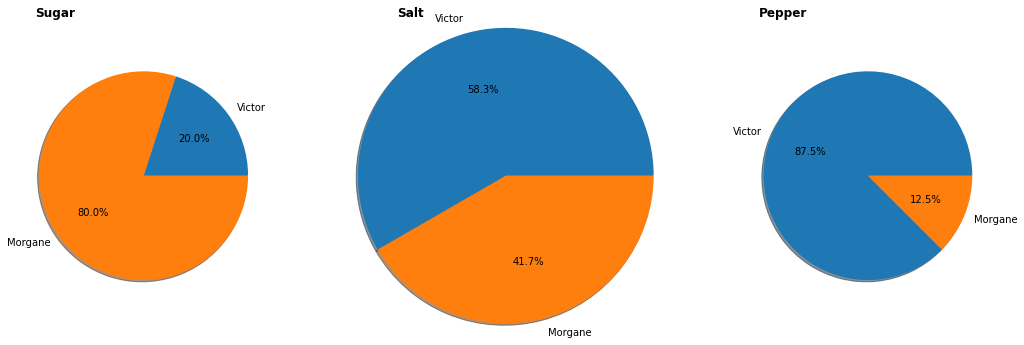

In [15]:
product_names = products.index
fig, axes = plt.subplots(1, product_names.size)

for i, name in enumerate(product_names):
    sales_index = products.loc[name].bought / 10
    data = products.loc[name][customers.columns]
    axes[i].pie(data, labels=data.index, radius=sales_index, autopct='%1.1f%%', shadow=True)
    axes[i].set_title(name, loc='left', pad=50.0, fontdict={'fontweight': 'bold'})
    
plt.subplots_adjust(right=2.5)
plt.show()

## Events

Query records from the event-store:

In [16]:
consumer = KafkaConsumer('events', 
                         bootstrap_servers=event_store,
                         value_deserializer=lambda x: json.loads(x.decode('utf-8')),
                         auto_offset_reset='earliest', 
                         enable_auto_commit=False,
                         consumer_timeout_ms=1000)
records = [record for record in consumer]
records[:3]

[ConsumerRecord(topic='events', partition=0, offset=0, timestamp=1588146594684, timestamp_type=0, key=None, value={'name': 'product_watched', 'version': 'v1.0', 'payload': {'product': 'Sugar', 'visitor': 'anonymous'}}, headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=103, serialized_header_size=-1),
 ConsumerRecord(topic='events', partition=0, offset=1, timestamp=1588146596826, timestamp_type=0, key=None, value={'name': 'product_watched', 'version': 'v1.0', 'payload': {'product': 'Salt', 'visitor': 'anonymous'}}, headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=102, serialized_header_size=-1),
 ConsumerRecord(topic='events', partition=0, offset=2, timestamp=1588146598671, timestamp_type=0, key=None, value={'name': 'product_watched', 'version': 'v1.0', 'payload': {'product': 'Pepper', 'visitor': 'anonymous'}}, headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=104, serialized_header_size=-1)]

Store records inside a DataFrame:

In [17]:
records = pd.DataFrame(records)
records.head()

,topic,partition,offset,timestamp,timestamp_type,key,value,headers,checksum,serialized_key_size,serialized_value_size,serialized_header_size
0,events,0,0,1588146594684,0,None,"{'name': 'product_watched', 'version': 'v1.0',...",[],None,-1,103,-1
1,events,0,1,1588146596826,0,None,"{'name': 'product_watched', 'version': 'v1.0',...",[],None,-1,102,-1
2,events,0,2,1588146598671,0,None,"{'name': 'product_watched', 'version': 'v1.0',...",[],None,-1,104,-1
3,events,0,3,1588146600660,0,None,"{'name': 'product_watched', 'version': 'v1.0',...",[],None,-1,103,-1
4,events,0,4,1588146602487,0,None,"{'name': 'product_watched', 'version': 'v1.0',...",[],None,-1,102,-1


Extract events from records:

In [18]:
events = pd.read_json(records.value.to_json(orient='records'))
events.head()

,name,version,payload
0,product_watched,v1.0,"{'product': 'Sugar', 'visitor': 'anonymous'}"
1,product_watched,v1.0,"{'product': 'Salt', 'visitor': 'anonymous'}"
2,product_watched,v1.0,"{'product': 'Pepper', 'visitor': 'anonymous'}"
3,product_watched,v1.0,"{'product': 'Sugar', 'visitor': 'anonymous'}"
4,product_watched,v1.0,"{'product': 'Salt', 'visitor': 'anonymous'}"


Extract payload from events and add timestamp from records:

In [19]:
events = events.join(pd.read_json(events.payload.to_json(orient='records')))
events.drop(['payload'], axis=1, inplace=True)
events['timestamp'] = records.timestamp
events.head()

,name,version,product,visitor,customer,timestamp
0,product_watched,v1.0,Sugar,anonymous,NaN,1588146594684
1,product_watched,v1.0,Salt,anonymous,NaN,1588146596826
2,product_watched,v1.0,Pepper,anonymous,NaN,1588146598671
3,product_watched,v1.0,Sugar,anonymous,NaN,1588146600660
4,product_watched,v1.0,Salt,anonymous,NaN,1588146602487


Filter `product_bought` events:

In [20]:
events[events.name == 'product_bought'].drop(['visitor'], axis=1).head()

,name,version,product,customer,timestamp
34,product_bought,v1.0,Sugar,Victor,1588146686452
35,product_bought,v1.0,Sugar,Victor,1588146686452
36,product_bought,v1.0,Salt,Victor,1588146686452
37,product_bought,v1.0,Salt,Victor,1588146686452
38,product_bought,v1.0,Salt,Victor,1588146686452


Filter events related to customer `Michele`:

In [21]:
events[(events.visitor == 'Michele') | (events.customer == 'Michele')].head()

,name,version,product,visitor,customer,timestamp
78,product_watched,v1.0,Sugar,Michele,NaN,1588146746198
79,product_watched,v1.0,Salt,Michele,NaN,1588146747927
80,product_watched,v1.0,Pepper,Michele,NaN,1588146750790
81,product_watched,v1.0,Salt,Michele,NaN,1588146752468
82,product_watched,v1.0,Pepper,Michele,NaN,1588146754156


Clean up data:

In [22]:
data = events.drop(['version', 'visitor', 'timestamp'], axis=1)
data.customer.fillna(events.visitor, inplace=True)
data.head()

,name,product,customer
0,product_watched,Sugar,anonymous
1,product_watched,Salt,anonymous
2,product_watched,Pepper,anonymous
3,product_watched,Sugar,anonymous
4,product_watched,Salt,anonymous


Count amount of events per type of event, customer, and product:

In [23]:
data = data.pivot_table(index=['name','product', 'customer'], aggfunc='size').unstack().fillna(0)
data

customer                 Max  Michele  Morgane  Victor  anonymous
name            product                                          
product_bought  Pepper   0.0      4.0      1.0     7.0        0.0
                Salt     1.0      4.0      5.0     7.0        0.0
                Sugar    2.0      0.0      8.0     2.0        0.0
product_watched Pepper   0.0      3.0      1.0     2.0        4.0
                Salt     1.0      4.0      2.0     4.0        8.0
                Sugar    3.0      4.0      4.0    10.0       13.0

Visualize repartition of events per customer and product:

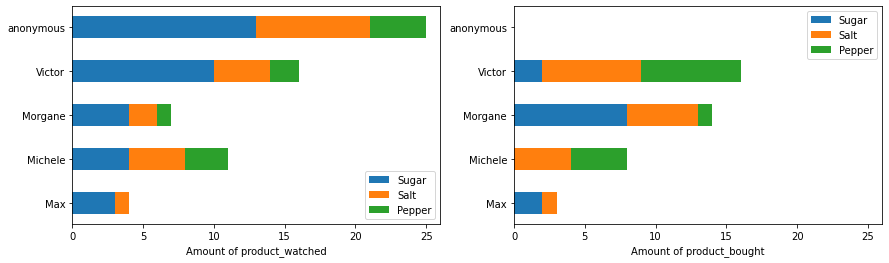

In [24]:
fig, axs = plt.subplots(1, 2)

x_limit = max(data.loc['product_watched'].sum().max(), 
              data.loc['product_bought'].sum().max()) + 1

def setup_chart(ax, event_name):
    sugars = data.loc[event_name].loc['Sugar']
    salts = data.loc[event_name].loc['Salt']
    peppers = data.loc[event_name].loc['Pepper']
    
    ax.barh(data.columns, sugars, 0.5, label='Sugar')
    ax.barh(data.columns, salts, 0.5, label='Salt', left=sugars)
    ax.barh(data.columns, peppers, 0.5, label='Pepper', left=sugars + salts)
    ax.set_xlabel(f'Amount of {event_name}')
    ax.set_xlim(right=x_limit)
    ax.legend()

setup_chart(axs[0], 'product_watched')    
setup_chart(axs[1], 'product_bought')

plt.subplots_adjust(right=2)
plt.show()